# Preprocessing for Fitzpatrick17K dataset

In [1]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import imageprocessing
from imageprocessing import ImageResize, MaskedImage
import preprocess_ham
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
db = "FITZ"
root = f"../../dataset/IEEE/{db}/"

In [3]:
# Skin lesion image
input_folder = root + "o_data/"
output_folder = root + "data/"

ir = ImageResize(input_folder, output_folder)
ir.resize()

Completed.


In [4]:
metafile = "fitzpatrick17k.csv"
df = pd.read_csv(root + metafile)

In [5]:
# Binary
df["three_partition_label"].unique()

array(['non-neoplastic', 'benign', 'malignant'], dtype=object)

In [6]:
# Rename columns to uniform datasets
df["image_id"] = df["md5hash"]
df["filename"] = df["md5hash"] + ".jpg"
df["filepath"] = root + "data/" + df["filename"]
df.loc[df["three_partition_label"] == "benign", "labels"] = "0"
df.loc[df["three_partition_label"] == "malignant", "labels"] = "1"
df["skin tone"] = df["fitzpatrick_scale"]

In [7]:
index = df[df["three_partition_label"] == "non-neoplastic"].index
df.drop(index=index, inplace=True)

### Split dataset
Dataset balance: train 60% validation 20% test 20%

In [8]:
column = "labels"
train_df, dummy_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=42, stratify=df[column])
valid_df, test_df= train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42, stratify=dummy_df[column])
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  2698   test_df length:  900   valid_df length:  899


### Balance dataset

In [9]:
max_samples=1000
min_samples= 100
column='labels'
train_df, classes, class_count = preprocess_ham.trim(train_df, max_samples, min_samples, column)

['0' '1']
dataframe initially is of length  2698  with  2  classes
after trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  100
the trimmed dataframe now is of length  2000  with  2  classes


In [10]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [11]:
n=1000
column='labels'
train_df = preprocess_ham.balance(train_df, n, root, img_size)

Initial length of dataframe is  2000
Total Augmented images created= 0
Length of augmented dataframe is now  2000


## ITA calculation and distance measure

In [12]:
from derm_ita import random_patches
import derm_ita
from skimage import io, color

In [13]:
filepath = f"{root}data/00a61ae0aa6d43a08152a7c4692ef9e2.jpg"
RGB = Image.open(filepath)
mean_ita = derm_ita.get_random_patches_ita(RGB)
ita, _ = random_patches.get_random_patches_ita_list(RGB)

/home/kuniko/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kuniko/anaconda3/lib/python3.11/site-packages/derm_ita/ita_core_computations.py:75: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
/home/kuniko/anaconda3/lib/python3.11/site-packages/derm_ita/ita_core_computations.py:86: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


Baseline File Path: ../../dataset/IEEE/FITZ/data/6d27e7fe9ac56869b5ee3158e4288f2d.jpg
Mean ITA: 59.98568756763994


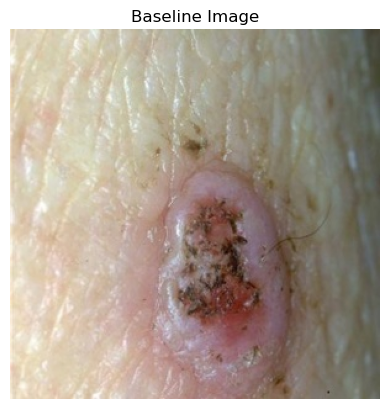

In [14]:
baseline = test_df.sample(n=1, random_state=42)
baseline_filepath = baseline["filepath"].values[0]
RGB = Image.open(baseline_filepath)
baseline_mean_ita = derm_ita.get_random_patches_ita(RGB)
baseline_nuance_ita, _ = random_patches.get_random_patches_ita_list(RGB)

print(f"Baseline File Path: {baseline_filepath}")
print(f"Mean ITA: {baseline_mean_ita}")

image = cv2.imread(baseline_filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")
plt.title("Baseline Image")
plt.show()

In [15]:
means = []
distances = []

for _, row in test_df.iterrows():
    filepath = row["filepath"]
    RGB = Image.open(filepath)
    mean_ita = derm_ita.get_random_patches_ita(RGB)
    means.append(mean_ita)
    nuance_ita, _ = random_patches.get_random_patches_ita_list(RGB)
    dm = DistanceMeasure(baseline_nuance_ita, nuance_ita)
    distance = dm.sign_wasserstein_distance()
    distances.append(distance)

test_df["mean ita"] = means
test_df["distance"] = distances
print("Complete")

Complete


## Data export

In [16]:
train_df.to_csv(f"{root}exp/train_df.csv", index=False)
valid_df.to_csv(f"{root}exp/valid_df.csv", index=False)
test_df.to_csv(f"{root}exp/test_df.csv", index=False)